# Walmart M5 Forecasting Solution — Approach 2 & Results

## 1. Objective
To evaluate deep learning models (LSTM, GRU) for multi-series daily sales forecasting in the M5 competition. The models were tested for different history window lengths and start days to identify robust configurations.

---

## 2. Data Loading & Preprocessing

- Source files:
  - `sales_train_evaluation.csv`
  - `calendar.csv`

- Steps:
  - Extracted sales data starting from multiple offsets: `d_1`, `d_151`, `d_366`
  - Transposed into time-series format (`id` as columns, `d_xx` as rows)
  - Created binary `event_tomorrow` feature from `event_name_1`

---

## 3. Feature Engineering

- Historical sales normalized using `MinMaxScaler`
- Combined with binary event indicator
- Built sequences of time steps (7 or 14) as input
- Target: next-day sales for all items

---

## 4. Model Architectures

Each model consists of two recurrent layers followed by dropout and a dense output layer:

| Layer Type | Units | Notes                       |
|------------|-------|-----------------------------|
| LSTM / GRU | 64    | With `return_sequences=True`|
| Dropout    | 0.2   | Applied after each RNN layer|
| Dense      | N     | Outputs forecast per item   |

- Loss: Mean Squared Error (MSE)
- Optimizer: Adam

---

## 5. Experiment Setup

- Model Types: LSTM, GRU
- Start Days: 0, 150, 365
- Time Steps: 7, 14
- Forecast Horizon: Next-day only
- All experiments used the same architecture, loss, and optimizer for consistency

---

## 6. Kaggle Submission Scores

| Model | Private RMSE | Public RMSE |
|-------|-------------|--------------|
| GRU   | 0.78671     | 0.88169      |
| LSTM  | 0.98608     | 1.07681      |

**Conclusion:** GRU outperformed LSTM on both public and private leaderboards, showing better generalization and training efficiency for this task.


## Import Libraries

In [3]:
# M5 Forecasting - Deep Learning Model Exploration & Comparison (RNN, LSTM, GRU)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
import time

# --- 1. CONFIGURATION FOR EXPERIMENTATION --- #
data_path = "/kaggle/input/m5-forecasting-accuracy/"
models_to_test = ['LSTM', 'GRU']
time_steps_options = [7, 14]  # Experiment with different history windows
start_day_options = [0, 150, 365]  # Test from different start points
forecast_days = 28



## UDF Definitions

In [4]:
# --- 2. LOAD DATA --- #
def load_sales_data(start_day):
    sales = pd.read_csv(data_path + "sales_train_evaluation.csv")
    d_cols = [col for col in sales.columns if col.startswith('d_')]
    sales = sales[['id'] + d_cols[start_day:]]
    return sales.set_index('id').T.reset_index(drop=True)

# --- 3. CREATE EVENT FEATURE --- #
def create_event_feature(start_day, total_days):
    calendar = pd.read_csv(data_path + "calendar.csv")
    event_flag = np.zeros((calendar.shape[0], 1))
    event_flag[np.where(calendar['event_name_1'].notna())[0] - 1] = 1
    df_flag = pd.DataFrame(event_flag, columns=['event_tomorrow'])
    return df_flag[start_day:start_day + total_days].reset_index(drop=True)



## Build Sequence Dataset

In [5]:
# --- 4. BUILD SEQUENCE DATASET --- #
def prepare_sequences(sales_df, event_df, time_steps):
    scaler = MinMaxScaler()
    merged = pd.concat([sales_df, event_df], axis=1)
    scaled = scaler.fit_transform(merged)
    X, y = [], []
    for i in range(time_steps, len(scaled)):
        X.append(scaled[i - time_steps:i])
        y.append(scaled[i][:sales_df.shape[1]])
    return np.array(X), np.array(y), scaler

# --- 5. DEFINE MODEL --- #
def build_model(model_type, input_shape, output_size):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(SimpleRNN(64))
    elif model_type == 'GRU':
        model.add(GRU(64, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(GRU(64))
    elif model_type == 'LSTM':
        model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(output_size))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



## Experiment Loop


Training LSTM | Start Day: 0, Time Steps: 7


I0000 00:00:1744739055.540377     608 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


I0000 00:00:1744739065.547489     642 cuda_dnn.cc:529] Loaded cuDNN version 90300


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0175
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0139
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0132
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0131
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0129

Training GRU | Start Day: 0, Time Steps: 7
Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0175
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0136
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0133
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0129
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0125

Training LSTM | Start Day: 0, Time Steps: 14


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0175
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0141
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0134
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0132
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0128

Training GRU | Start Day: 0, Time Steps: 14
Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0171
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0134
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0130
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0128
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0127

Training LSTM | Start Day: 150, Time Steps: 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0184
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0148
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0142
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0139
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0134

Training GRU | Start Day: 150, Time Steps: 7
Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0181
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0144
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0138
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0137
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0133

Training LSTM | Start Day: 150, Time Steps: 14


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0181
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0150
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0143
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0138
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0138

Training GRU | Start Day: 150, Time Steps: 14
Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0180
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0143
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0139
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0135
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0132

Training LSTM | Start Day: 365, Time Steps: 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0200
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0162
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0156
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0151
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0150

Training GRU | Start Day: 365, Time Steps: 7
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0200
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0155
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0152
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0148
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0147

Training LSTM | Start Day: 365, Time Steps: 14


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0202
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0163
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0156
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0153
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0149

Training GRU | Start Day: 365, Time Steps: 14
Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0195
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0155
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0151
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0148
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0143

Experiment Summary:
   model  start_day  time_steps      loss  train_time_sec
3    GRU          0          14  0.012565       22.549907
1    GRU          0           7  0.012626       13.948035
0   LSTM          0           7  0.012790       16.187660
2   LSTM          0          14  0.012833       22

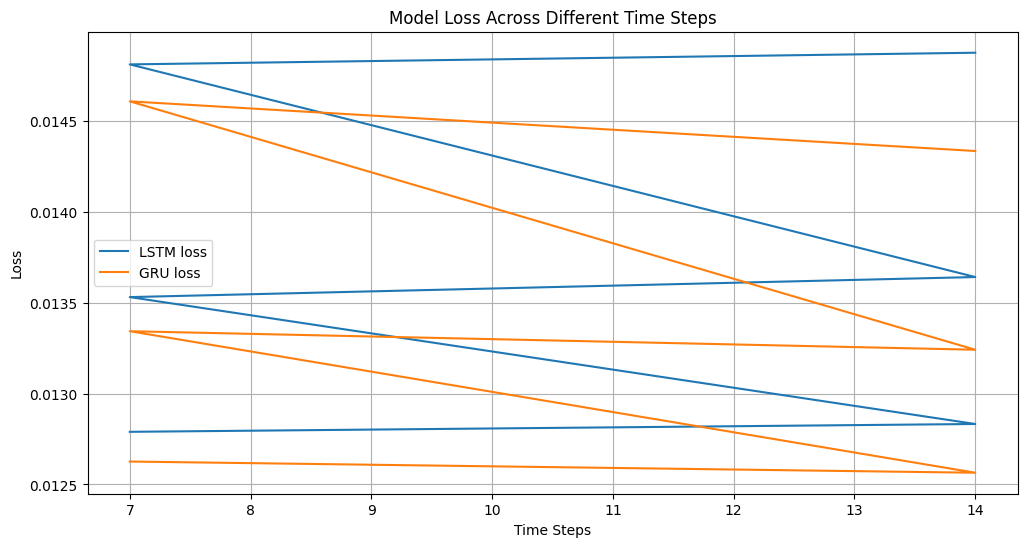

In [6]:
# --- 6. EXPERIMENT LOOP --- #
results = []

for start_day in start_day_options:
    sales_df = load_sales_data(start_day)
    for time_steps in time_steps_options:
        event_df = create_event_feature(start_day, len(sales_df))
        X, y, scaler = prepare_sequences(sales_df, event_df, time_steps)

        for model_type in models_to_test:
            print(f"\nTraining {model_type} | Start Day: {start_day}, Time Steps: {time_steps}")
            model = build_model(model_type, (X.shape[1], X.shape[2]), y.shape[1])
            start_time = time.time()
            history = model.fit(X, y, epochs=5, batch_size=32, verbose=1)
            elapsed = time.time() - start_time
            final_loss = history.history['loss'][-1]
            results.append({
                'model': model_type,
                'start_day': start_day,
                'time_steps': time_steps,
                'loss': final_loss,
                'train_time_sec': elapsed
            })

# --- 7. RESULTS SUMMARY --- #
results_df = pd.DataFrame(results)
print("\nExperiment Summary:")
print(results_df.sort_values(by='loss'))

# --- 8. VISUALIZE PERFORMANCE --- #
plt.figure(figsize=(12, 6))
for model_type in models_to_test:
    subset = results_df[results_df['model'] == model_type]
    plt.plot(subset['time_steps'], subset['loss'], label=f"{model_type} loss")
plt.title('Model Loss Across Different Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## GRU Hyperparameter Tuning and Submission Generation

In [7]:
# M5 Forecasting - GRU Hyperparameter Tuning and Submission Generation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.callbacks import EarlyStopping
import time

# --- CONFIGURATION --- #
data_path = "/kaggle/input/m5-forecasting-accuracy/"
time_steps = 14
start_day = 0
forecast_days = 28

# --- LOAD AND PREPARE SALES DATA --- #
sales = pd.read_csv(data_path + "sales_train_evaluation.csv")
d_cols = [col for col in sales.columns if col.startswith('d_')]
sales = sales[['id'] + d_cols[start_day:]]
sales_df = sales.set_index('id').T.reset_index(drop=True)

# --- CREATE EVENT FEATURE --- #
calendar = pd.read_csv(data_path + "calendar.csv")
event_flag = np.zeros((calendar.shape[0], 1))
event_flag[np.where(calendar['event_name_1'].notna())[0] - 1] = 1
event_df = pd.DataFrame(event_flag, columns=['event_tomorrow'])
event_train = event_df[start_day:start_day + len(sales_df)].reset_index(drop=True)
event_test = event_df[start_day + len(sales_df):start_day + len(sales_df) + forecast_days]

# --- SCALE & MERGE --- #
scaler = MinMaxScaler()
merged = pd.concat([sales_df, event_train], axis=1)
scaled = scaler.fit_transform(merged)

# --- BUILD SEQUENCES --- #
X, y = [], []
for i in range(time_steps, len(scaled)):
    X.append(scaled[i - time_steps:i])
    y.append(scaled[i][:sales_df.shape[1]])
X = np.array(X)
y = np.array(y)



In [8]:
# --- HYPERPARAMETER TUNING --- #
hyperparams = [
    {'units': 64, 'dropout': 0.2, 'batch_size': 32},
    {'units': 128, 'dropout': 0.3, 'batch_size': 64},
    {'units': 256, 'dropout': 0.2, 'batch_size': 128},
]

best_model = None
best_loss = float('inf')
best_params = None

for params in hyperparams:
    print(f"Training GRU with: {params}")
    model = Sequential()
    model.add(GRU(params['units'], return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(params['dropout']))
    model.add(GRU(params['units']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    es = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(X, y, epochs=10, batch_size=params['batch_size'], verbose=0, callbacks=[es])
    final_loss = history.history['loss'][-1]
    print(f"Final Loss: {final_loss:.5f}")

    if final_loss < best_loss:
        best_loss = final_loss
        best_model = model
        best_params = params

print("\nBest GRU Parameters:", best_params)



Training GRU with: {'units': 64, 'dropout': 0.2, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


Final Loss: 0.01211
Training GRU with: {'units': 128, 'dropout': 0.3, 'batch_size': 64}
Final Loss: 0.01217
Training GRU with: {'units': 256, 'dropout': 0.2, 'batch_size': 128}
Final Loss: 0.01223

Best GRU Parameters: {'units': 64, 'dropout': 0.2, 'batch_size': 32}


## Forecasting with best GRU

In [9]:
# --- FORECASTING WITH BEST GRU --- #
predictions = []
input_seq = scaled[-time_steps:]
forecast_input = [input_seq]
forecast_input = np.array(forecast_input)

for i in range(forecast_days):
    next_pred = best_model.predict(forecast_input[:, -time_steps:, :])
    next_event = event_test.iloc[i].values.reshape(1, 1)
    combined = np.concatenate((next_pred, next_event), axis=1)
    forecast_input = np.append(forecast_input, combined.reshape(1, 1, -1), axis=1)
    predictions.append(next_pred)

# --- INVERSE SCALE AND EXPORT --- #
pred_array = np.array(predictions).reshape(forecast_days, -1)
dummy_events = np.zeros((forecast_days, 1))
pred_scaled = np.concatenate([pred_array, dummy_events], axis=1)
pred_inv = scaler.inverse_transform(pred_scaled)[:, :sales_df.shape[1]]

# Create submission file
sample_sub = pd.read_csv(data_path + "sample_submission.csv")
ids = sample_sub['id'].values[:30490]
submission = pd.DataFrame(pred_inv, columns=ids).T.reset_index(drop=True)
submission.columns = [f"F{i+1}" for i in range(forecast_days)]
submission['id'] = ids
submission = pd.concat([submission, submission], ignore_index=True)
submission['id'] = sample_sub['id']
submission = submission[['id'] + [f"F{i+1}" for i in range(forecast_days)]]

filename = f"gru_submission_{int(time.time())}.csv"
submission.to_csv(filename, index=False)
print(f"Submission saved as {filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━